<a href="https://colab.research.google.com/github/emmaritcey/CISC372/blob/master/SampleCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# download data (-q is the quiet mode)
! wget -q https://www.dropbox.com/s/lhb1awpi769bfdr/test.csv?dl=1 -O test.csv
! wget -q https://www.dropbox.com/s/gudb5eunj700s7j/train.csv?dl=1 -O train.csv

In [0]:
import pandas as pd

Xy_train = pd.read_csv('train.csv', engine='python') #read in training data
X_train = Xy_train.drop(columns=['price_rating']) #drop price_rating column from training data
y_train = Xy_train[['price_rating']] #use price_rating column as training data labels

In [0]:
X_train.head() #see first five rows of dataframe of training data to get idea of the attributes/features

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,...,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Id
0,https://www.airbnb.com/rooms/31864146,2019-11-19,"1400 sqf, sleeps 8, heart of MTL, with balcony","Spacious, sunny and cozy modern apartment in t...",Design by an interior decorator born and raise...,"Spacious, sunny and cozy modern apartment in t...",none,I have no problem saying out loud that this is...,NaN,NaN,NaN,It is my pleasure to make sure that my guest a...,- no loud music after 12am - smoking allowed o...,NaN,NaN,https://a0.muscache.com/im/pictures/5a84171f-f...,NaN,237107097,https://www.airbnb.com/users/show/237107097,Robert,2019-01-16,CA,NaN,within an hour,97%,NaN,f,https://a0.muscache.com/im/pictures/user/e4869...,https://a0.muscache.com/im/pictures/user/e4869...,Cote-des-Neiges,13.0,13.0,"['email', 'phone', 'offline_government_id', 's...",t,f,"Montréal, Québec, Canada",Le Plateau,Le Plateau-Mont-Royal,NaN,Montréal,...,2,1125,2,2,1125,1125,2.0,1125.0,a week ago,t,12,31,61,166,2019-11-19,51,51,2019-02-03,2019-11-11,85.0,8.0,8.0,9.0,9.0,10.0,9.0,f,NaN,"{Quebec,"" CA""}",t,f,moderate,f,f,7,7,0,0,5.28,14664
1,https://www.airbnb.com/rooms/6909303,2019-11-19,*** Lovely apartment downtown ***,Located in one of the most vibrant and accessi...,This condo (700 s.f) has a closed bedroom plus...,Located in one of the most vibrant and accessi...,none,"Great neighbourhood, walking distance from Pee...",NaN,Bonaventure metro station Bus Public parking,You will have access to all four rooftops with...,NaN,- No Party allowed - No smoking or pets inside...,NaN,NaN,https://a0.muscache.com/im/pictures/8b4c172a-8...,NaN,16880424,https://www.airbnb.com/users/show/16880424,Sam,2014-06-16,"Montreal, Québec, Canada","Professional and friendly, speaks french and e...",within an hour,93%,NaN,f,https://a0.muscache.com/im/users/16880424/prof...,https://a0.muscache.com/im/users/16880424/prof...,Griffintown,2.0,2.0,"['email', 'phone', 'reviews', 'selfie']",t,f,"Montréal, Québec, Canada",Downtown Montreal,Le Sud-Ouest,NaN,Montréal,...,6,1125,6,6,1125,1125,6.0,1125.0,2 weeks ago,t,14,25,55,304,2019-11-19,3,1,2018-04-02,2019-11-11,93.0,10.0,10.0,10.0,10.0,10.0,9.0,f,NaN,"{Quebec,"" CA""}",f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.15,2542
2,https://www.airbnb.com/rooms/28134621,2019-11-19,Appartement chaleureux près du centre-ville,Logement coquet et douillet à 10 minutes du ce...,Vous aurez accès au logement en entier pour y ...,Logement coquet et douillet à 10 minutes du ce...,none,NaN,NaN,"L’autobus 32 passe au coin, à 1min. de marche ...",Vous avez accès au logement en entier incluant...,Je suis totalement disponi

traning 7631


(7631, 101)

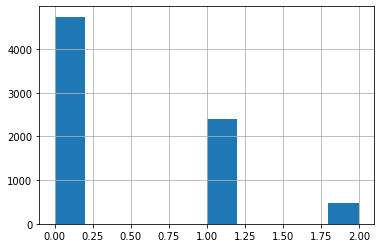

In [0]:
print('traning', len(X_train)) #print the number of records in the training data
Xy_train.price_rating.hist() #create histogram of training data labels
X_train.shape #prints the number of records and the number of attributes

In [0]:
X_test = pd.read_csv('test.csv', engine='python') #read in testing data
testing_ids = X_test.Id #save Id column as testing_ids
print('testing', len(X_test)) #print number of records in testing data

testing 7632


In [0]:
# model training and tuning
#import all necessary functions and packages
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier

np.random.seed(0) #makes the same random numbers each time script is run, creates consistency for testing

#extract a few of the numeric features from training data
numeric_features = ['bedrooms', 'review_scores_location', 'accommodates', 'beds']
#for numeric features replace all missing values with median of column and use StandardScaler as standardizing method
#use pipeline so that these steps can be applied all at once
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#extract a few of the categorical features from training data
categorical_features = [
  'property_type', 'is_business_travel_ready', 'room_type', ]
#for categorical features replace all missing values with 'missing' and use one-hot encoding to transform into vector
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#create preprocessor that applies the two transformers above to the applicable columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#create new pipeline that first applies preprocessor created above to the data and then uses xgboost as classifier
regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', XGBClassifier(
                          objective='multi:softmax', seed=1))])


In [0]:
#change X_train to the dataframe that only contains features used in numeric_features and categorical_features
X_train = X_train[[*numeric_features, *categorical_features]]
X_test = X_test[[*numeric_features, *categorical_features]]

#see new dataframe of training data
X_train.head()

,bedrooms,review_scores_location,accommodates,beds,property_type,is_business_travel_ready,room_type
0,2.0,10.0,8,4.0,Apartment,f,Entire home/apt
1,1.0,10.0,3,2.0,Apartment,f,Entire home/apt
2,2.0,8.0,2,1.0,Apartment,f,Entire home/apt
3,2.0,10.0,6,2.0,Apartment,f,Entire home/apt
4,2.0,10.0,9,3.0,Apartment,f,Entire home/apt


In [0]:
#param_grid contains all the hyperparameters to be tested using GridSearchCV

# `__` denotes attribute 
# (e.g. regressor__n_estimators means the `n_estimators` param for `regressor`
#  which is our xgb)
#test 50 and 100 estimators
#test max depths of 10 and 20
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth':[10, 20]
}

#use GridSearchCV to find best parameters to use
grid_search = GridSearchCV(
    regr, param_grid, cv=5, verbose=3, n_jobs=2, 
    scoring='accuracy')
#fit the model to training data
grid_search.fit(X_train, y_train)
#grid_search.best_score prints the best accuracy obtained using the various parameters in param_grid
print('best score {}'.format(grid_search.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   40.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best score 0.6945360101828082


In [0]:
#save best model
xgb_best = grid_search.best_estimator_

In [0]:
#check which parameter values were the best
print(grid_search.best_params_)

{'preprocessor__num__imputer__strategy': 'mean', 'regressor__max_depth': 10, 'regressor__n_estimators': 100}


In [0]:
# Prediction & generating the submission file
y_pred = grid_search.predict(X_test) #makes predictions of the classes of the test data
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
#save predictions to csv file
pd.DataFrame(
    {'Id': testing_ids, 'price_rating':y_pred}).to_csv('sample_submission.csv', index=False)